In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

WORLDX, WORLDY = 10, 6 

## Gradiente

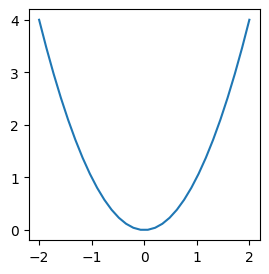

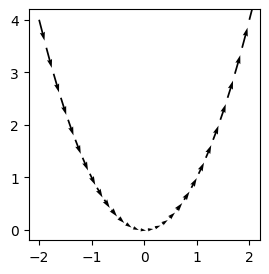

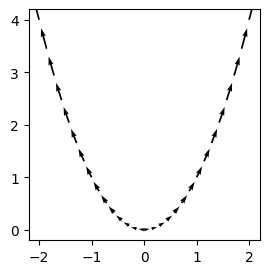

In [4]:
# Atenção com a ordem dos pontos
xn = np.linspace(0, -2, 15)
xp = np.linspace(0, 2, 15)
x =  np.linspace(-2, 2, 30)
y = x**2


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
plt.plot(x, y)


dx = np.gradient(x)
dy = np.gradient(y)

fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
ax.quiver(x, y, dx, dy)


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

y = xn**2
dx = np.gradient(xn)
dy = np.gradient(y)
ax.quiver(xn, y, dx, dy)

y = xp**2
dx = np.gradient(xp)
dy = np.gradient(y)
ax.quiver(xp, y, dx, dy)

## Attraction force

(0.0, 6.0)

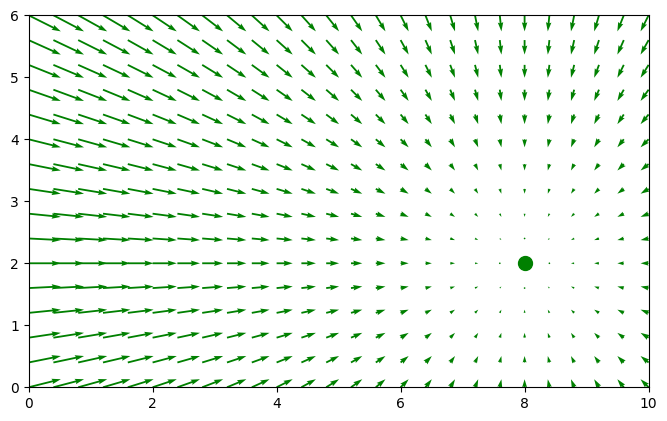

In [5]:
def att_force(q, goal, katt=.01):
    return katt*(goal - q)

goal = np.array([8, 2])

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

XX, YY = np.meshgrid(np.arange(0, WORLDX+.4, .4), np.arange(0, WORLDY+.4, .4))
XY = np.dstack([XX, YY]).reshape(-1, 2)

Fatt = att_force(XY, goal)
Fatt_x = Fatt[:,0] 
Fatt_y = Fatt[:,1]

ax.quiver(XX, YY, Fatt_x, Fatt_y, color='g')

plt.plot(goal[0], goal[1], 'og', markersize=10)
    
ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)